Отвечаем на проверочные вопросы по лекциям: https://goo.gl/forms/51XSzyoE92MtvDWF2

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Support Vector Machine

Рассмотрим наглядные примеры применения SVM для решения бинарной задачи классификации на двумерных модельных данных. Для начала рассмотрим случай, когда выборка линейно разделима. Напомним, что линейный алгоритм SVM ищёт разделяющую прямую (в общем случае гиперплоскость), максимизирующую зазор между классами. Проведём три разделяющих прямых, с различной шириной разделяющей полосы.

In [5]:
# http://scikit-learn.org/stable/modules/svm.html

from sklearn.datasets.samples_generator import make_classification

X, y = make_classification(n_samples=50, n_features=2, n_informative=2, 
                            n_redundant=0, n_clusters_per_class=1, random_state=0)#генерирует  класса, 50 точек
X[:5]

array([[ 1.35758444,  1.21647643],
       [ 0.66417453,  0.56898498],
       [ 0.18394517,  1.2191645 ],
       [ 0.8440956 ,  1.07805264],
       [-2.22518661, -0.00323656]])

In [6]:
# Вывести точки данных на график (scatter)

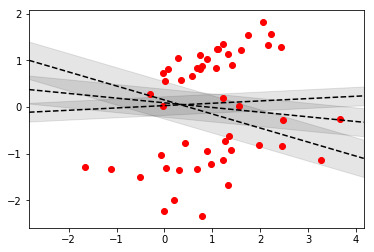

In [60]:
# выводим разделяющие гиперплоскости
x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)
for a, b, w in [(-0.1, 0.09, 0.3), (0.05, 0.03, 0.2), (-0.3, 0.15, 0.4)]:
    y_line = a * x_line + b
    plt.plot(x_line, y_line, '--k')
    plt.fill_between(x_line, y_line - w, y_line + w, color='k', alpha=0.1)
plt.xlim(x_line[0], x_line[-1])
plt.scatter(X[:,0],X[:,1], color = 'red')
plt.show()

Обучим линейный SVM и отобразим результат на рисунке. Выделенные объекты называются *опорными векторами* - они лежат на границе разделяющей полосы.

In [51]:
from sklearn.svm import SVC

# Fitting linear SVM model

lin_svm = SVC(kernel='linear', C=10).fit(X, y)

In [52]:
# Какой отступ у точки [1,0]? А у [0,1]?
lin_svm.coef_

array([[ 4.09259041, -2.08557192]])

In [53]:
# Какие же точки являются опорными?

In [54]:
def plot_svc_decision_function(clf, ax=None): #clf - классификатор
    if ax is None:
        ax = plt.gca()#get current axes - gca
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)#декартово произведение
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]]) #decision_function - типо > 0 один класс, < 0 другой класс; 
            #расстояние до гиперплоскости
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '-.']) #contour - проводит линии уровня (чё)
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], #support_vectors_ - возвращает опорные вектора
            s=200, facecolors='none', edgecolors='k')

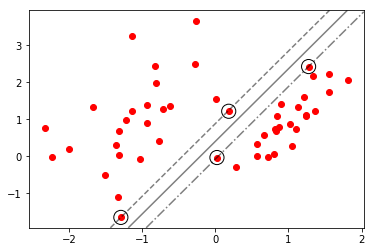

In [62]:
plt.scatter(X[:,0],X[:,1], color = 'red')
plot_svc_decision_function(lin_svm)

In [48]:
# Вывести точки вместе с разделюящими плоскостями

### Полиномиальное ядро

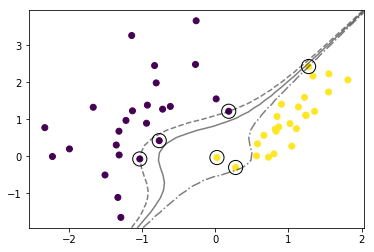

In [65]:
poly_svm = SVC(kernel='poly', C=15).fit(X, y)
# Вывести точки вместе с разделюящими плоскостями
plt.scatter(X[:,0],X[:,1], c = y)
plot_svc_decision_function(poly_svm)

### Radial basis function kernel

Рассмотрим влияние параметров gamma и С при использовании RBF ядра

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target


X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [ ]:
scores = grid.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

In [ ]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.94))
plt.xlabel('$\gamma$')
plt.ylabel('$C$')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

In [ ]:
plt.figure(figsize=(16, 12))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("$\gamma=10^{%d}, C=10^{%d}$" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

Рассмотрим теперь случай, когда выборка не является линейно разделимой. Типичный примеры - это концентрические окружности. Обучим линейный SVM и посмотрим на результат.

In [ ]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(n_samples=100, factor=0.1, 
                    noise=0.1, random_state=0)

# Вывести точки вместе с разделюящими плоскостями

## Kernel trick

Как видно, линейные разделяющие поверхности никак не могут дать хорошего качества классификации, в случае такой явно выраженной линейной неразделимости. Напомним, что переход к двойственной задаче оптимизации в алгоритме SVM позволил переписать решающую функцию как сумму скалярных произведений объектов с некоторыми коэффициентами. Заменяя эти скалярные произведения $\langle x_i, x_i \rangle$ на ядровую функцию $K(x_i, x_j) = \langle \varphi(x_i), \varphi(x_j) \rangle$, которая представляет собой скалярное произведение образов исходных объектов в некотором пространстве большей размерности, мы получаем возможность строить более сложные разделяющие поверхности в исходном пространстве. 

Стоит отметить, вычисление значений $K(x_i, x_j)$ может быть сильно упрощено и оптимизировано во многих важных частных случаях, и реализация SVM в sklearn использует такие трюки. Например, в случае полиномиального ядра степени 2, для вычисления значения $K(x_i, x_j)$ не нужно сначала вычислять образы $\varphi(x_i), \varphi(x_j)$, используя формулу:

<center>
<img src="https://upload.wikimedia.org/math/1/5/7/157b3f647240fdce86ca1c96c55943f2.png">
</center>

а затем вычислять скалярное произведение этих векторов в новом пространстве большей размерности. Достаточно вычислить значение $K(x_i, x_j) = (\langle x_i, x_j \rangle + c)^2$. Таким образом, для основных ядер вычисление значения $K(x_i, x_j)$ сводится к вычислению скалярных произведений в исходном (маломерном) пространстве, что позволяет избежать вычисления преобразования $\varphi(x)$ и существенно ускоряет работу алгоритма.

Указанная выше выборка может быть линейно разделена в пространстве размерности 3. Переход туда можно осуществить многими способами. Для начала рассмотрим использование полиномиального ядра степени 2. Ниже приведён образ выборки в трёхмерном пространстве. Видно, что в новом пространстве выборка может быть легко разделена с помощью плоскости.

Описание доступных в scikitlearn ядровых функций можно тут [3]. В scikitlearn есть следующие встроенные функции:

1. линейная (linear): $$\langle x, x'\rangle.$$
2. полиномиальная (polynomial): $$(\gamma \langle x, x'\rangle + r)^d$$ d указывается через degree, r через coef0.
3. Radial basis function kernel rbf[4]: $$\exp(-\gamma |x-x'|^2)$$ $\gamma$ указывается через gamma> 0.
4. sigmoid: $$(\tanh(\gamma \langle x,x'\rangle + r))$$ r указывается через coef0.

In [ ]:
from ipywidgets import interact
from mpl_toolkits import mplot3d

r = X[:, 0] ** 2 + X[:, 1] ** 2

def plot_3D(elev=30, azim=30):
    plt.figure(figsize=(10,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45, 0, 30, 45, 90], azip=(-180, 180))

Обучим SVM с полиномиальным ядром степени 2 и посмотрим на результат его работы в исходном пространстве. Получаем безошибочное разделение выборки на два класса. Заметим, что опорные объекты уже необязательно лежат на границе разделяющей полосы, в отличие от случая линейно разделимой выборки.

In [ ]:
poly_svm = SVC(kernel='poly', degree=2).fit(X, y)

# Вывести точки вместе с разделюящими плоскостями - какие они теперь?

Второй способ вложения исходной выборки в трёхмерное пространство использует так называемое RBF-ядро (от radial basis functions). Посмотрим на результат этого вложения:

In [ ]:
re = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

def plot_3D(elev=30, azim=30):
    plt.figure(figsize=(10,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], re, c=y, s=70, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45, 0, 30, 45, 90], azip=(-180, 180))

Обучим SVM с RBF-ядром и посмотрим на результат его работы в исходном пространстве. Также как и в случае полиномиального ядра получаем безошибочную классификацию.

In [ ]:
rbf_svm = SVC(kernel='rbf').fit(X, y)

# Вывести точки вместе с разделюящими плоскостями - а что теперь?

RBF-ядро позволяет строить значительно более сложные поверхности по сравнению с полиномиальным ядром (поскольку формально происходит переход в бесконечномерное пространство), однако это может стать причиной переобучения. Чтобы избежать его, необходимо правильно подбирать параметры ядра. Посмотрим на поведение разделяющей поверхности при изменении объёма выборки, а также при изменении параметра $\gamma$:

In [ ]:
def plot_svm(N=100, gamma=0.0):
    # А тут код генрации данных и обучения SVC с необходимым параметром
    pass
    
interact(plot_svm, N=[10, 10, 200], gamma=[-3.0, 0, 1.0])

### Построение собственного ядра

In [ ]:
# http://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#example-svm-plot-custom-kernel-py

X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
Y = iris.target

In [ ]:
def my_kernel(X, Y):
    """
    We create a custom kernel:

                 (2  0)
    k(X, Y) = X  (    ) Y.T
                 (0  1)
    """
    # Что же здесь за вычисления?
    pass

# we create an instance of SVM and fit out data.
clf = SVC(kernel=my_kernel)
clf.fit(X, Y)

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.title('3-Class classification using Support Vector Machine with custom'
          ' kernel')
plt.axis('tight')
plt.show()

### Достоинства SVM

- Эффективная работа в многомерном пространстве.
- Высокая общающая способность. Различные ядровые функции могут использоваться для обучения.


### Недостатки SVM

- Низкая устойчивость к шумовым данным
- Необходимость подбора параметра регуляризации C


## Полезные ссылки
1. SVM: [wiki](https://en.wikipedia.org/wiki/Support_vector_machine) и [machinelearning](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%B0_%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2)
2. [Kernel trick](https://en.wikipedia.org/wiki/Kernel_method)
3. http://scikit-learn.org/stable/modules/svm.html#svm-kernels
4. [Kernels Part 1: What is an RBF Kernel? Really?](https://charlesmartin14.wordpress.com/2012/02/06/kernels_part_1/)